## PyTorch Inference Optimization 

## E6692 Spring 2022

In this notebook you will measure the throughput of your custom trained YOLOv4-Tiny model.

In [1]:
import torch # import modules
import sys
import time
import numpy as np
import time
import sys

from darknet_utils.darknet_to_pytorch import load_pytorch, load_darknet_as_pytorch # import custom modules
from darknet_utils.inference import measure_throughput, plot_execution_times

cfg_path = './cfg/yolov4-tiny-person-vehicle.cfg' # path to configuration file of custom model

# torch_weights_path = './darknet/backup/yolov4-tiny-person-vehicle_best.weights' # path to JIT optimized model
torch_weights_path = './darknet/backup/yolov4-tiny-person-vehicle_best.pt'

device = 'cuda'

%load_ext autoreload
%autoreload 2

**TODO:** Load the custom trained YOLOv4-Tiny PyTorch model in the cell below. 

TIP: If you don't want to see the model summary, you can insert `%%capture` as the first line in the cell to hide all output.

In [2]:
# %%capture
# TODO: load the custom trained YOLOv4-Tiny with load_pytorch()

#UnpicklingError: invalid load key, '\x00'.
# pytorch_model = load_pytorch(cfg_path, torch_weights_path) 

# use the other function to load the model and change it to evaluation mode
pytorch_model = load_darknet_as_pytorch(cfg_path, torch_weights_path)
pytorch_model.eval()

Darknet(
  (models): ModuleList(
    (0): Sequential(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky3): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): EmptyModule()
    (4): Sequential(
      (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn4):

### Define throughput in the context of deep learning models.

**TODO:** Your answer here.

Throughput refers to the number of data units processed in one unit of time.

**TODO:** Complete the function **measure_throughput()** in **darknet_utils/inference.py**.

In [3]:
# TODO: use measure_throughput() to measure the throughput of your PyTorch YOLOv4-Tiny
#       what is a reasonable input shape to measure throughput?
measure_throughput(pytorch_model, (1,3,480,640))

118.2225032598324

Now you will investigate the PyTorch [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation) functionality to further optimize YOLOv4-Tiny for inference on the Jetson Nano. [PyTorch JIT](https://pytorch.org/docs/stable/jit.html) has two methods for converting a standard PyTorch model to a [TorchScript](https://pytorch.org/docs/stable/jit.html#:~:text=TorchScript%20is%20a%20way%20to,there%20is%20no%20Python%20dependency.) model - script and trace. Torchscript models are optimizable and serializable. That means they can be saved independently from Python and used in other contexts like a C++ program. 

### What is meant by eager execution and graph execution?

**TODO:** Your answer here.

Eager execution is an imperative, define-by-run interface where operations are executed immediately as they are called from Python.

Graph execution mode is a symbolic computational framework. It needs to first construct a graph explaining what the opetations are, then create a session for computing.

### Explain the difference between "script" and "trace". When would you use jit.script and when would you use jit.trace? Why do you need to include a sample input when using jit.trace?

**TODO:** Your answer here.

Scripting a function or nn.Module will inspect the source code, compile it as TorchScript code using the TorchScript compiler, and return a ScriptModule or ScriptFunction.

Trace a function and return an executable or ScriptFunction that will be optimized using just-in-time compilation.

Trace is suitable for operations that do not require conditions based on data, like standard convolutional neural network. If there;s condition operations, script are more suitable to be used.



Because the function will recording the operations performed on the example inputs.

**TODO:** Use `torch.jit.trace()` to create a traced TorchScript model. Save the traced model weights to the weights directory with `torch.jit.save()`.

In [4]:
# TODO: Use torch.jit to generate a traced PyTorch version of YOLOv4-Tiny.

save_path = './weights/jit_trace_model_weights.pt'

example_forward_input = torch.rand(1,3,480,640).to(device)
pytorch_model.cuda()
# traced_model = torch.jit.trace()
traced_model = torch.jit.trace(pytorch_model.forward, example_forward_input)

# traced_model
torch.jit.save(traced_model, save_path)

In [5]:
# Verify that output of traced model matches output of original model

input_array = torch.randn((4, 3, 480, 640)).to(device) # define input tensor

torch_output = pytorch_model(input_array)[0].cpu().detach().numpy() # pass input through models
jit_output = traced_model(input_array)[0].cpu().detach().numpy()

print("JIT traced model matches PyTorch: ", np.allclose(torch_output, jit_output)) # compare outputs

JIT traced model matches PyTorch:  True


In [7]:
# TODO: use measure_throughput() to measure the throughput of your traced YOLOv4-Tiny
measure_throughput(traced_model, (1,3,480,640))

139.48398258631784

**TODO:** Calculate and plot throughput as a function of batch size for both models. Calculate throughput for the largest batch size you can fit into the Jetson Nano's memory. You're welcome to use **plot_execution_times()** or your own plotting function.

In [22]:
# TODO: calculate throughput as a function of batch size for both models
def throughput_bs(model, batch_sizes):
    
    throughput_list = []
    for bs in batch_sizes:
        throughput_list.append(measure_throughput(model, (bs,3,480,640), warmup_iterations=10, iterations=20))
    
    return throughput_list

batch_sizes = list(np.arange(0,101,10))
batch_sizes[0] = 1

tp_list_pytorch = throughput_bs(pytorch_model, batch_sizes)
tp_list_traced = throughput_bs(traced_model, batch_sizes)


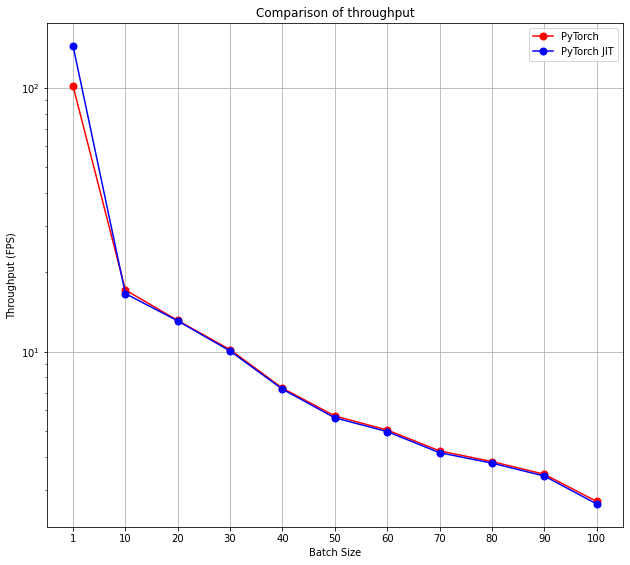

In [23]:
# TODO: plot throughput as a function of batch size for both models
title = 'Comparison of throughput'

plot_execution_times(tp_list_pytorch, tp_list_traced, title, batch_sizes,
                         marker_size=7, logy=True, figsize=(8, 7))

### Discuss the results of your throughput measurements. Are there any surprising results? Which batch sizes result in the largest throughputs? Is this batch size reasonable to use in real-time applications?

**TODO:** Your answer here.

Except when the batch size is 1, the performance of both model are the same.

When the batch size is the smallest, which is 1, both model has the highest result and the traced model is better (about 5-10% percent of improvement) than the pytorch model. 

In real-time applications, 5-10% of improvement means a lot, it can handle more data in an unit time without improve the hardware. In image detection tasks, this means a higher fps.